In [1]:
%matplotlib inline

# DeepFake換臉(pytorch)

In [15]:
import matplotlib
import matplotlib.pyplot as plt

import pylab
import PIL  
from PIL import Image
import os
import pickle
import codecs
import glob
import math
import cv2
import dlib
import imutils
from imutils.face_utils import *
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.modules import *
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _single, _pair, _triple
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# 是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
#宣告臉部偵測器，以及載入預訓練的臉部特徵點模型
detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')


In [4]:
FACE_POINTS = range(17, 68) #臉的輪廓
MOUTH_POINTS = range(48, 68) #嘴
RIGHT_BROW_POINTS =range(17, 22) #右眉毛
LEFT_BROW_POINTS = range(22, 27) #左眉毛
RIGHT_EYE_POINTS = range(36, 42) #右眼
LEFT_EYE_POINTS =range(42, 48) #左眼
NOSE_POINTS = range(27, 35) #鼻子
#JAW_POINTS = range(0, 17) #下巴
ALIGN_POINTS = [LEFT_BROW_POINTS , RIGHT_EYE_POINTS ,LEFT_EYE_POINTS,RIGHT_BROW_POINTS ,NOSE_POINTS , MOUTH_POINTS]


def Get_landmarks_2D(image):
    w=image.shape[1]
    h=image.shape[0]
    padding=5
    scale=(128-2*padding)/max([image.shape[0],image.shape[1]])

    mean_face_x_ratio = np.array([
        0.000213256, 0.0752622, 0.18113, 0.29077, 0.393397, 0.586856, 0.689483, 0.799124,
        0.904991, 0.98004, 0.490127, 0.490127, 0.490127, 0.490127, 0.36688, 0.426036,
        0.490127, 0.554217, 0.613373, 0.121737, 0.187122, 0.265825, 0.334606, 0.260918,
        0.182743, 0.645647, 0.714428, 0.793132, 0.858516, 0.79751, 0.719335, 0.254149,
        0.340985, 0.428858, 0.490127, 0.551395, 0.639268, 0.726104, 0.642159, 0.556721,
        0.490127, 0.423532, 0.338094, 0.290379, 0.428096, 0.490127, 0.552157, 0.689874,
        0.553364, 0.490127, 0.42689])

    mean_face_y_ratio = np.array([
        0.106454, 0.038915, 0.0187482, 0.0344891, 0.0773906, 0.0773906, 0.0344891,
        0.0187482, 0.038915, 0.106454, 0.203352, 0.307009, 0.409805, 0.515625, 0.587326,
        0.609345, 0.628106, 0.609345, 0.587326, 0.216423, 0.178758, 0.179852, 0.231733,
        0.245099, 0.244077, 0.231733, 0.179852, 0.178758, 0.216423, 0.244077, 0.245099,
        0.780233, 0.745405, 0.727388, 0.742578, 0.727388, 0.745405, 0.780233, 0.864805,
        0.902192, 0.909281, 0.902192, 0.864805, 0.784792, 0.778746, 0.785343, 0.778746,
        0.784792, 0.824182, 0.831803, 0.824182])

    mean_face_x=mean_face_x_ratio*w*scale+padding
    mean_face_y = mean_face_y_ratio*h*scale+padding
    landmarks_2D = np.stack([mean_face_x, mean_face_y], axis=1)
    return landmarks_2D

In [5]:
def umeyama(src, dst, estimate_scale):
    """估計N維相似性轉換參數(可處理有無縮放之狀況) 
    ----------
    src : (M, N) array
        來源點座標
    dst : (M, N) array
        參考點座標
    estimate_scale : bool
        是否估計縮放因子
    Returns
    -------
    T : (N + 1, N + 1)
        The homogeneous similarity transformation matrix. The matrix contains
        NaN values only if the problem is not well-conditioned.
    
    參考文獻
    ----------
    .. [1] "Least-squares estimation of transformation parameters between two
            point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    """

    num = src.shape[0]
    dim = src.shape[1]

    # 計算src 以及 dst的均值
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    #將 src 與 dst 減去均值
    src_demean = src - src_mean
    dst_demean = dst  - dst_mean

    # Eq. (38).
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

In [6]:
#生成影像mask
def get_image_mask(image,landmarks):
    image_mask=np.zeros(image.shape,dtype=float)
    for points in ALIGN_POINTS:
        try:
            
            hull =cv2.convexHull( np.array(landmarks[points,:] ).reshape((-1,2)).astype(int) ).flatten().reshape( (-1,2) )
            cv2.fillConvexPoly(image_mask,hull,(255,255,255) )
        except Exception as e:
            print(e)
    return image_mask

#生成對齊校準後的影像以及對應的mask
def get_align_face(image,mask,landmarks,size):
    landmarks_2D=Get_landmarks_2D(image)
    
    src_tmp = np.asarray([(int(xy[0]), int(xy[1])) for xy in landmarks[17:]])
    tar_tmp = np.asarray([(int(xy[0]), int(xy[1])) for xy in landmarks_2D])

    M = umeyama(src_tmp,tar_tmp, True)[:2,:]
    align_face = cv2.warpAffine(image, M, (size[1],size[0]), borderMode=cv2.BORDER_REPLICATE)
    align_mask = cv2.warpAffine(mask, M, (size[1], size[0]), borderMode=cv2.BORDER_REPLICATE)
    return align_face,align_mask,M

#生成臉部區域mask
def get_face_area_mask(image,landmarks):
    new_landmarks=landmarks.copy()
    new_landmarks[17:27]+=np.array([0,-2]) #眉上2個像素
    new_landmarks=np.clip(new_landmarks,0,max(image.shape[0],image.shape[1]))
    image_mask=np.zeros(image.shape,dtype=np.float32)
    try:
        hull =cv2.convexHull( np.array(landmarks[:27,:] ).reshape((-1,2)).astype(int) ).flatten().reshape( (-1,2) )
        cv2.fillConvexPoly(image_mask,hull,(255,255,255) )
    except Exception as e:
        print(e)
    image_mask = cv2.blur(image_mask,(7,7)) #邊緣模糊化
    return image_mask


![deepfake](../Images/face_preprocessed.jpg)

In [7]:
#自注意力機制
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1) #

    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N
        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        out = self.gamma*out + x
        return out
def toTensor(img):
    img = torch.from_numpy(img)
    return img


def var_to_np(img_var):
    return img_var.data.cpu().numpy()

def conv5x5(in_planes, out_planes, stride=1,dilation=1,padding=2):
    return nn.Conv2d(in_planes, out_planes, kernel_size=5, stride=stride,padding=padding, dilation =dilation, bias=False)

def conv3x3(in_planes, out_planes, stride=1,dilation=1,padding=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=padding,dilation =dilation, bias=False)
def conv1x1(in_planes, out_planes, stride=1,dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,dilation =dilation, bias=False)


class Flatten(nn.Module):
    def forward(self, input):
        output = input.view(input.size(0), -1)
        return output


class UpScale(nn.Module):
    def __init__(self, inplanes, stride=1):
        super(UpScale, self).__init__()
        self.conv1 = conv3x3(inplanes, inplanes*2)
        self.relu = nn.LeakyReLU(0.2)
        self.pixelshuffler =nn.PixelShuffle(2)
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.pixelshuffler(out)
        return out

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            conv5x5(3, 32),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            conv3x3(32, 64,stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            conv3x3(64, 128,stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            Self_Attn(128, 'relu'),
            conv3x3(128, 256,stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            conv3x3(256, 512,stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            Flatten(),
            nn.Linear(32768, 1024),
            nn.Linear(1024, 512 * 8 * 8),
        )

        self.decoder_A = nn.Sequential(
            UpScale(512, 256),
            UpScale(256, 128),
            Self_Attn(128, 'relu'),
            UpScale(128, 64),
            UpScale(64, 32),
            #UpScale(32, 16),
            conv5x5(32, 3),
            nn.Sigmoid(),
        )

        self.decoder_B = nn.Sequential(
           UpScale(512, 256),
            UpScale(256, 128),
            Self_Attn(128, 'relu'),
            UpScale(128, 64),
            UpScale(64, 32),
            #UpScale(32, 16),
            conv5x5(32, 3),
            nn.Sigmoid(),
        )
    def forward(self, x, select='A'):
        
        if select == 'A':
            out = self.encoder(x)
            out = out.view(-1, 512, 8, 8) 
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = out.view(-1, 512, 8, 8) 
            out = self.decoder_B(out)
        return out

In [8]:
model = Autoencoder()
if os.path.exists('Models/deepfake_pytorch.cnn'):
    model = torch.load('Models/deepfake_pytorch.cnn')
    print('載入既有模型累積訓練!!')
model=model.to(device)

載入既有模型累積訓練!!


In [9]:
def color_hist_match(new, frame, image_mask):
    for channel in [0, 1, 2]:
        new[:, :, channel] = hist_match(new[:, :, channel],frame[:, :, channel], image_mask[:, :, channel])
    return new

def hist_match(new, frame, image_mask):
    orig=new.copy()
    mask_indices = np.nonzero(image_mask)
    if len(mask_indices[0]) == 0:
        return new
    m_new = new[mask_indices].ravel()
    m_frame = frame[mask_indices].ravel()
    s_values, bin_idx, s_counts = np.unique(m_new, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(m_frame, return_counts=True)
    s_quants = np.cumsum(s_counts, dtype='float32')
    t_quants = np.cumsum(t_counts, dtype='float32')
    s_quants /= s_quants[-1]  # cdf
    t_quants /= t_quants[-1]  # cdf
    interp_s_values = np.interp(s_quants, t_quants, t_values)
    new.put(mask_indices, interp_s_values[bin_idx])
    return new

In [10]:
#換臉方法(methoid)
#direct:直接貼過去(最醜)
#masked:透過臉部區域mask融合
#skin_masked:透過臉部區域mask融合同時加入膚色校準處理


#換臉函數
#輸入 img為含有人臉的圖片  to_whom表示是換成誰
#輸出為將內的人臉區域找出來置換為to_whom的臉
def faceswap(img, to_whom='jolin',method='masked'):
    global autoencoder_A,autoencoder_B
    #檢測人臉區域
    face_rects = detector(img, 1)
    max_area_rect=None
    max_area=0
    #以圖中最大面積做為臉(偶而會出現誤檢，但通常面積很小，所以取最大面積是最保險的)
    for i, d in enumerate(face_rects):
        #讀取框左上右下座標
        x1 = d.left()
        y1 = d.top()
        x2 = d.right()
        y2 = d.bottom()
        #計算面積
        area=(y2-y1)*(x2-x1)
        if area>max_area:
            max_area= area
            max_area_rect=d
    x1 = max_area_rect.left()
    y1 = max_area_rect.top()
    x2 = max_area_rect.right()
    y2 = max_area_rect.bottom()  
        
    #在臉部位置挖取圖片
    corp_img = img[y1:y2, x1:x2, :]
    cv2.imwrite('crop_img0.jpg',corp_img.copy())
    
    #取得臉部區域的特徵點
    d=dlib.rectangle(0, 0,corp_img.shape[0], corp_img.shape[1])
    shape=landmark_predictor(corp_img, d)
    landmark = shape_to_np(shape)

    corp_img1=corp_img.copy()
    for (x, y) in landmark:
        cv2.circle(corp_img1, (x, y), 2, (215, 120, 0), -1)
    cv2.imwrite('crop_img.jpg',corp_img1)
    
    try:
        #取得臉部區域的五官mask
        image_mask=get_image_mask(corp_img,landmark)
        cv2.imwrite('image_mask.jpg',image_mask)
   
        #取得對齊後的臉部區域圖片以及五官mask以及對應的轉換矩陣M(之後會用到)
        #將圖片從原本臉的大小轉為128*128
        align_face,align_mask,M=get_align_face(corp_img,image_mask,landmark,(128,128))#取得轉換函數
        cv2.imwrite('align_face.jpg',align_face)
        cv2.imwrite('align_mask.jpg',align_mask)
   
        #選擇模型
        select="A"
        if to_whom=='president':
            select="B"
        
        #將圖片轉為CHW以及減去127.5除以127.5
        #np.expand_dims功能在於做出批次維
        feature=np.expand_dims((np.transpose(align_face,[2, 0, 1])-127.5)/127.5,0).astype(np.float32) 
        feature=toTensor(feature).to(device).float()
        
        #透過模型產生重建圖像
        output=model(feature,select)
        
        #預測結果為對齊過的新臉
        #將預測結果轉為HWC以及乘以127.5再加上127.5，變回正常圖片
        output=np.transpose(var_to_np(output)[0],[1,2,0])*127.5+127.5
        
        #將輸出複製一份
        new_face =output.copy()
        #找出這個新臉的特徵點位置
        d_current=dlib.rectangle(0, 0,128,128)
        shape_current=landmark_predictor(align_face, d_current)
        landmark_current = shape_to_np(shape_current)
        
        new_image = output.copy()
        for (x, y) in landmark_current:
            cv2.circle(new_image, (x, y), 2, (215, 120, 0), -1)
        cv2.imwrite('output.jpg',new_image)
        
        #產生新臉的臉部區域MASK(此時是對齊的臉)
        new_mask=get_face_area_mask(new_face,landmark_current)
        cv2.imwrite('new_mask.jpg',new_mask)
        
        #把對齊過的臉轉回原本的位置
        #請注意cv2.WARP_INVERSE_MAP表示是根據M進行逆轉換
        #將圖片從128*128轉為原本臉的大小
        new_face=cv2.warpAffine(new_face, M, (corp_img.shape[1],corp_img.shape[0]), new_face, cv2.WARP_INVERSE_MAP, cv2.BORDER_REPLICATE)
        cv2.imwrite('dealign_face.jpg',new_face)
        
        #臉部區域MASK也進行一樣的逆轉換
        new_mask=cv2.warpAffine(new_mask, M, (corp_img.shape[1],corp_img.shape[0]), new_mask, cv2.WARP_INVERSE_MAP, cv2.BORDER_CONSTANT,0)
        cv2.imwrite('dealign_mask.jpg',new_mask)
        
        if method=='direct':
            #將逆轉換後的臉直接貼回到原有圖片中
            img[y1:y1+new_face.shape[0], x1:x1+new_face.shape[1], :]=new_face
        
        elif method=='masked':
            #請注意，這邊是除以255.而不是new_mask[new_mask>0]=1，因為再生成臉部區域時有進行BLUR，因此不是二值化的MASK
            #有小數點的MASK可以比較漸進式的融合臉部而不會顯得很突兀
            new_mask/=255. #blur
            #將原始的臉以及新的臉，透過五官區域MASK融合
            new_face=new_face*new_mask+(1-new_mask)*corp_img
            cv2.imwrite('merged_face.jpg',new_face)

            #將融合後的臉貼回到原有圖片中
            img[y1:y1+new_face.shape[0], x1:x1+new_face.shape[1], :]=new_face
        elif method=='skin_masked':
            #請注意，這邊是除以255.而不是new_mask[new_mask>0]=1，因為再生成臉部區域時有進行BLUR，因此不是二值化的MASK
            #有小數點的MASK可以比較漸進式的融合臉部而不會顯得很突兀
            new_mask/=255. #blur
        
            new_face =color_hist_match(new_face,corp_img,image_mask)
            #銳化影像
            blur=cv2.GaussianBlur(new_face,(0,0),3)
            new_face=cv2.addWeighted(new_face,1.5,blur,-0.5,0)


            cv2.imwrite('color_adj_face.jpg',new_face)
            
            #將原始的臉以及新的臉，透過五官區域MASK融合
            new_face=new_face*new_mask+(1-new_mask)*corp_img
            cv2.imwrite('merged_face.jpg',new_face)

            #將融合後的臉貼回到原有圖片中
            img[y1:y1+new_face.shape[0], x1:x1+new_face.shape[1], :]=new_face
        
        
        
    except Exception as e:
        print(e)
        
    return img
        
        
        
    

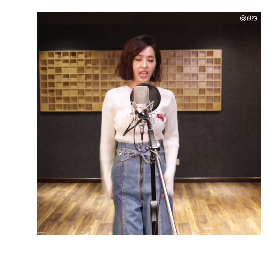

In [13]:
imgs=glob.glob('images data/jolin frames/frame_*.jpg')
img = cv2.imread(random.choice(imgs))
img1=img.copy()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img1)

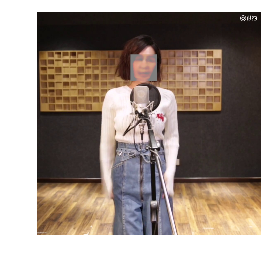

In [16]:

new_img1=faceswap(img.copy(),'president','direct')
new_img1 = cv2.cvtColor(new_img1, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(new_img1)

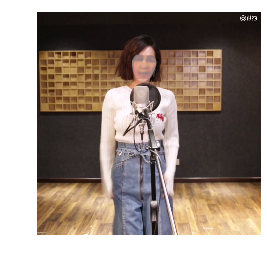

In [17]:
new_img2=faceswap(img.copy(),'president','masked')
new_img2 = cv2.cvtColor(new_img2, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(new_img2)

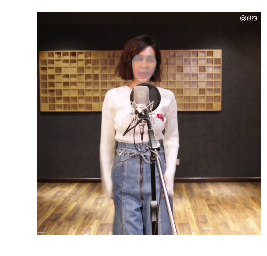

In [18]:
new_img3=faceswap(img.copy(),'president','skin_masked')
new_img3 = cv2.cvtColor(new_img3, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(new_img3)

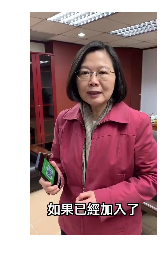

In [19]:
imgs=glob.glob('images data/president frames/frame_*.jpg')
img = cv2.imread(random.choice(imgs[:250]))
img1=img.copy()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img1)

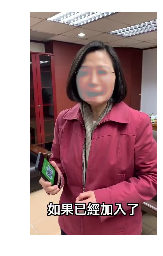

In [20]:
new_img3=faceswap(img.copy(),'jolin','skin_masked')
new_img3 = cv2.cvtColor(new_img3, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(new_img3)